## Airline On-Time Performance: A study on Logistic Regression

The purpose of this notebook is to get used to perform simple logistic regression using `scikit-leaarn` python library.
For this we are going tu use a subset of a dataset from the *United States Department of Transportation* about flight arrival and departure details for all commercial flights within the USA from year 2008.

The dataset is a `csv` of several megabytes, compressed using the `bz2` algorithm. For convenience purpose, we will limit ourselves to the first 100,000 rows.

The following table gives some description of the data:

Variable Name      | Description
-------------------|---------------------------------------
 Year              | 2008 in this case
 Month             | From 1 to 12
 DayofMonth        | From 1 to 31
 DayOfWeek         | 1 (Monday) to 7 (Sunday)
 DepTime           | Actual departure time (local, hhmm)
 CRSDepTime        | Scheduled departure time (local, hhmm)
 ArrTime           | Actual arrival time (local, hhmm)
 CRSArrTime        | Scheduled arrival time (local, hhmm)
 UniqueCarrier     | Unique carrier code
 FlightNum         | Flight number
 TailNum           | Plane tail number
 ActualElapsedTime | In minutes
 CRSElapsedTime    | In minutes
 AirTime           | In minutes
 ArrDelay          | Arrival delay, in minutes
 DepDelay          | Departure delay in minutes
 Origin            | Origin IATA airport code
 Dest              | Destination IATA airport code
 Distance          | In miles
 TaxiIn            | Taxi in time, in minutes
 TaxiOut           | Taxi out time, in minutes
 Cancelled         | Flight cancelled? (0 = No, 1 = Yes)
 CancellationCode  | Reason for cancellation (A = Carrier, B = Weather, C = NAS, D = Security)
 Diverted          | Flight diverted? (0 = No, 1 = Yes)
 CarrierDelay      | In minutes
 WeatherDelay      | In minutes
 NASDelay          | In minutes
 SecurityDelay     | In minutes
 LateAircraftDelay | In minutes

The data can be downloaded from [this URL](http://stat-computing.org/dataexpo/2009/2008.csv.bz2).

We will first proceed with data exploration, trying to find some relations between the different variables, then we'll move on with the prediction part.

### 1 - Preliminary Work:

This part focuses on loading the libraries into the workset and pre-processing the data.

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

import os.path as path
import urllib2

from random import sample
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn import feature_selection, metrics
from sklearn.grid_search import GridSearchCV

from __future__ import unicode_literals

# Define some global options
%matplotlib inline
pd.set_option('max_columns', 30)
pd.set_option('max_rows', 20)
sns.set_context(context = 'talk')

# Define some global variables
DATA_PATH = "Data/2008.csv.bz2"
DATA_URL = "http://stat-computing.org/dataexpo/2009/2008.csv.bz2"
USER_AGENT = "Mozilla/5.0 (Windows NT 6.1; WOW64; rv:37.0) Gecko/20100101 Firefox/37.0"

The next helper function is used to fetch the data; as the data file is larger than 100M, it doesn't fit on a standard github repository; one has to download it and/or keep it on the local machine.

The helper function will check for the file in the local data directory. If it is not there, the file will be downloaded.

In [12]:
def fetchData(dpath, url, agent):
    if path.isfile(dpath):
        return pd.read_csv(dpath, nrows = 100000, compression = 'bz2')
    else:
        req = urllib2.Request(url)
        req.add_header("User_Agent", agent)
        response = urllib2.urlopen(req)
        CHUNK_SIZE = 16 * 1024
        with open(dpath, 'wb') as infile:
            while True:
                chunk = response.read(CHUNK_SIZE)
                if not chunk: 
                    break
                infile.write(chunk)
        return pd.read_csv(dpath, nrows = 100000, compression = 'bz2')

Load the dataset, keep only the first 100,000 observations.

In [13]:
fd = fetchData(DATA_PATH, DATA_URL, USER_AGENT)

In [14]:
print('Number of observations: {}'.format(len(fd)))
fd.head(10)

Number of observations: 100000


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003,1955,2211,2225,WN,335,N712SW,128,150,116,-14,8,IAD,TPA,810,4,8,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754,735,1002,1000,WN,3231,N772SW,128,145,113,2,19,IAD,TPA,810,5,10,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628,620,804,750,WN,448,N428WN,96,90,76,14,8,IND,BWI,515,3,17,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926,930,1054,1100,WN,1746,N612SW,88,90,78,-6,-4,IND,BWI,515,3,7,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829,1755,1959,1925,WN,3920,N464WN,90,90,77,34,34,IND,BWI,515,3,10,0,NaN,0,2,0,0,0,32
5,2008,1,3,4,1940,1915,2121,2110,WN,378,N726SW,101,115,87,11,25,IND,JAX,688,4,10,0,NaN,0,NaN,NaN,NaN,NaN,NaN
6,2008,1,3,4,1937,1830,2037,1940,WN,509,N763SW,240,250,230,57,67,IND,LAS,1591,3,7,0,NaN,0,10,0,0,0,47
7,2008,1,3,4,1039,1040,1132,1150,WN,535,N428WN,233,250,219,-18,-1,IND,LAS,1591,7,7,0,NaN,0,NaN,NaN,NaN,NaN,NaN
8,2008,1,3,4,617,615,652,650,WN,11,N689SW,95,95,70,2,2,IND,MCI,451,6,19,0,NaN,0,NaN,NaN,NaN,NaN,NaN
9,2008,1,3,4,1620,1620,1639,1655,WN,810,N648SW,79,95,70,-16,0,IND,MCI,451,3,6,0,NaN,0,NaN,NaN,NaN,NaN,NaN


We are interested in the flights that were delayed so we will drop all those who where diverted or cancelled; in addition
we will drop the labels featuring only `NA` values.

For the record, we consider as on-time any plane arriving with 0 or whatever negative value in minutes (meaning they actually arrived earlier than scheduled) for the `ArrDelay` label.

We want also to keep track of the hour of the `CRSDepTime` as a new `DepHour` label.

In [15]:
fd = fd[(fd['Diverted'] == 0) & (fd['Cancelled'] == 0)].dropna(how = 'all')
fd['Delayed'] = fd.ArrDelay > 0
fd.replace({'Delayed' : {True : 'Delayed', False : 'Ontime'}}, inplace = True)
fd['DepHour'] = fd.CRSDepTime.apply(lambda x: int(x/100))

In [16]:
print('Number of observations: {}'.format(len(fd)))
fd.head(10)

Number of observations: 98698


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,...,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Delayed,DepHour
0,2008,1,3,4,2003,1955,2211,2225,WN,335,N712SW,128,150,116,-14,...,IAD,TPA,810,4,8,0,NaN,0,NaN,NaN,NaN,NaN,NaN,Ontime,19
1,2008,1,3,4,754,735,1002,1000,WN,3231,N772SW,128,145,113,2,...,IAD,TPA,810,5,10,0,NaN,0,NaN,NaN,NaN,NaN,NaN,Delayed,7
2,2008,1,3,4,628,620,804,750,WN,448,N428WN,96,90,76,14,...,IND,BWI,515,3,17,0,NaN,0,NaN,NaN,NaN,NaN,NaN,Delayed,6
3,2008,1,3,4,926,930,1054,1100,WN,1746,N612SW,88,90,78,-6,...,IND,BWI,515,3,7,0,NaN,0,NaN,NaN,NaN,NaN,NaN,Ontime,9
4,2008,1,3,4,1829,1755,1959,1925,WN,3920,N464WN,90,90,77,34,...,IND,BWI,515,3,10,0,NaN,0,2,0,0,0,32,Delayed,17
5,2008,1,3,4,1940,1915,2121,2110,WN,378,N726SW,101,115,87,11,...,IND,JAX,688,4,10,0,NaN,0,NaN,NaN,NaN,NaN,NaN,Delayed,19
6,2008,1,3,4,1937,1830,2037,1940,WN,509,N763SW,240,250,230,57,...,IND,LAS,1591,3,7,0,NaN,0,10,0,0,0,47,Delayed,18
7,2008,1,3,4,1039,1040,1132,1150,WN,535,N428WN,233,250,219,-18,...,IND,LAS,1591,7,7,0,NaN,0,NaN,NaN,NaN,NaN,NaN,Ontime,10
8,2008,1,3,4,617,615,652,650,WN,11,N689SW,95,95,70,2,...,IND,MCI,451,6,19,0,NaN,0,NaN,NaN,NaN,NaN,NaN,Delayed,6
9,2008,1,3,4,1620,1620,1639,1655,WN,810,N648SW,79,95,70,-16,...,IND,MCI,451,3,6,0,NaN,0,NaN,NaN,NaN,NaN,NaN,Ontime,16


### 2- Exploratory Data Analysis:

The purpose is to perform several plots in order to get a sense of the data and maybe predict some of the most useful features for the classification.

D:\Anaconda\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


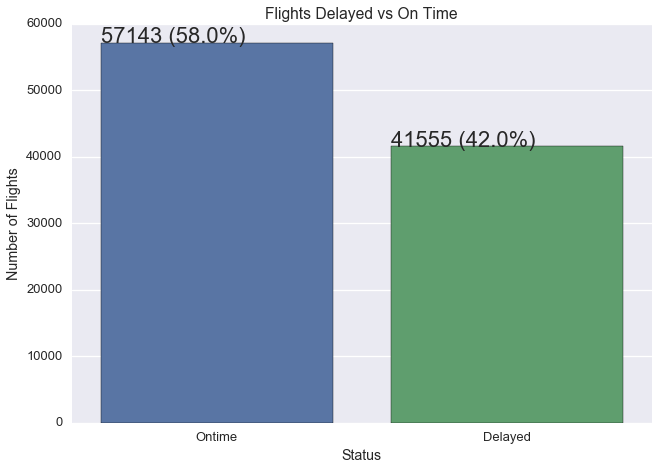

In [17]:
def plotHistogram():
    total = fd['Delayed'].value_counts().sum()
    g = sns.countplot(x = 'Delayed', data = fd)
    g.set_title('Flights Delayed vs On Time')
    g.set_yticks(np.arange(0, 70000, 10000))
    g.set(ylabel = 'Number of Flights', xlabel = 'Status')
    for p in g.patches:
        g.text(p.get_x(), p.get_height(),
               '{} ({}%)'.format(int(p.get_height()), np.round(p.get_height()/total*100)),
               fontsize = 22)

plotHistogram()

The dataset is relatively balanced; we may not need to balance the training dataset between `Ontime` and `Delayed` to get the best results. 

In [18]:
def displayPercent():
    data = pd.DataFrame(fd.UniqueCarrier.value_counts()).reset_index()
    data.columns = ['Carrier', 'Count']
    data['Percent'] = np.round(data.Count/data.Count.sum()*100, 1)
    print(data)

displayPercent()

  Carrier  Count  Percent
0      WN  92831     94.1
1      XE   5867      5.9


The dataset displays the data only for 2 carriers, namely:

* `WN` $\Rightarrow$ Southwest Airlines Co.
* `XE` $\Rightarrow$ ExpressJet Airlines Inc.

In [19]:
print('Months: {}'.format(set(fd.Month.values)))
print('Day of the month: {}'.format(set(fd.DayofMonth.values)))

Months: set([1])
Day of the month: set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])


This dataset accounts only for January (`Month= 1`); even if each day of the month is represented, this probably does not give us enough monthly history to extract a possible pattern.

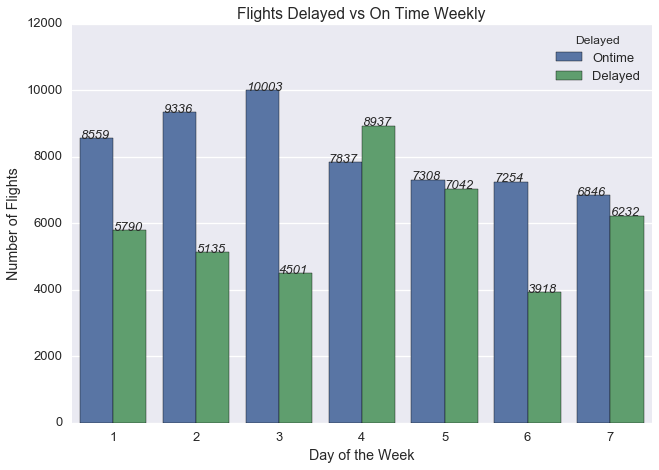

In [20]:
def displayStatusWeekly():
    g = sns.countplot(x = 'DayOfWeek', hue = 'Delayed', data = fd, order = np.arange(1, 8, 1))
    g.set_title('Flights Delayed vs On Time Weekly')
    g.set(ylabel = 'Number of Flights', xlabel = 'Day of the Week')
    for p in g.patches:
        g.text(p.get_x(), p.get_height(), '{}'.format(int(p.get_height())),
               fontstyle = 'oblique', fontsize = 13)

displayStatusWeekly()

Looks like Thursdays (`DayOfWeek = 4`) are more prone to delayed flights... Fridays and Sundays exhibit values that are almost balanced. During other days, on-time flights are predominant with a ratio close to `2/1` (except for Mondays where the ratio is closer to `3/2`).

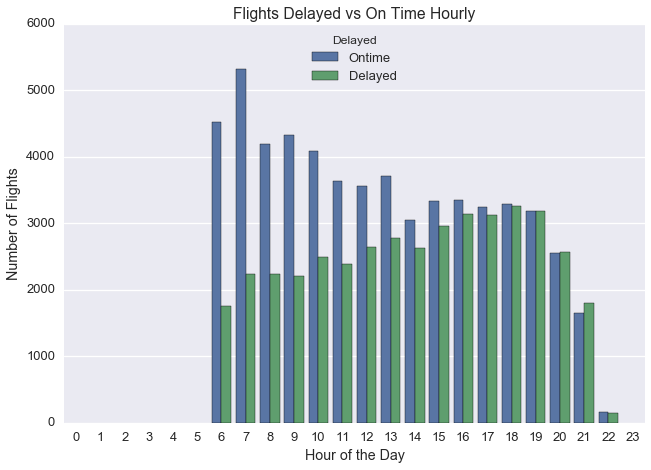

In [21]:
def displayStatusHourly():
    g = sns.countplot(x = 'DepHour', hue = 'Delayed', data = fd, order = np.arange(0, 24, 1))
    g.set_title('Flights Delayed vs On Time Hourly')
    g.set(ylabel = 'Number of Flights', xlabel = 'Hour of the Day')

displayStatusHourly()

It looks like there is a trend, with the number of delayed flights becoming increasingly more important in the evening...

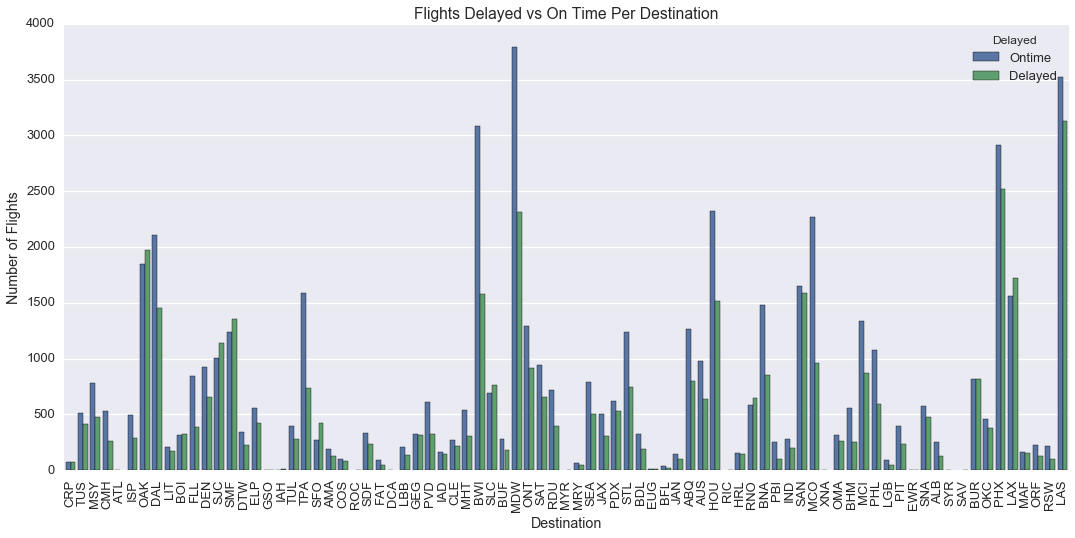

In [22]:
def displayStatusPerDestination():
    labels = set(fd.Dest.values)
    with sns.plotting_context(rc = {'figure.figsize' : (18,8)}):
        g = sns.countplot(x = 'Dest', hue = 'Delayed', data = fd, order = labels)
        g.set_title('Flights Delayed vs On Time Per Destination')
        g.set(ylabel = 'Number of Flights', xlabel = 'Destination')
        g.set_xticklabels(labels, rotation = 90)

displayStatusPerDestination()

The most frequent destinations are:

* Chicago Midway International Airport (MDW)
* Baltimore/Washington International Airport (BWI)
* Phoenix Sky Harbor International Airport (PHX)
* Las Vegas McCarran International Airport (LAS)

In proportion, Phoenix and Las Vegas suffer more delayed flights than Chicago and Baltimore.

However, several destinations suffer either an equal proportion of delayed flights with respect to the on-time ones or a bigger one, among those:

* Corpus Christi International Airport (CRP)
* Oakland International Airport (OAK)
* Boise Gowen Field Air Terminal (BOI)
* San Jose Norman Y. Mineta International Airport (SJC)
* Sacramento International Airport (SMF)
* Etc...

Those seem to be small- to medium-sized airports.

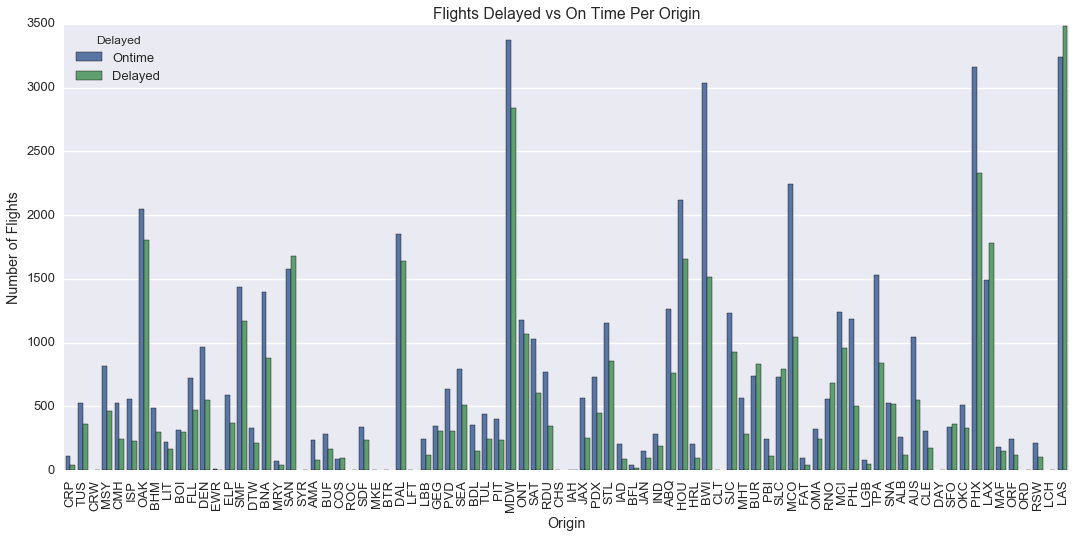

In [23]:
def displayStatusPerOrigin():
    labels = set(fd.Origin.values)
    with sns.plotting_context(rc = {'figure.figsize' : (18,8)}):
        g = sns.countplot(x = 'Origin', hue = 'Delayed', data = fd, order = labels)
        g.set_title('Flights Delayed vs On Time Per Origin')
        g.set(ylabel = 'Number of Flights', xlabel = 'Origin')
        g.set_xticklabels(labels, rotation = 90)

displayStatusPerOrigin()

The most common origins are the same as the most common destination. However, aircraft FROM Las Vegas are apparently more prone to delays than aircrafts TO Las Vegas.

Some origins display the same tendency to delays as some destinations (RNO, LAX), others not (SMF).

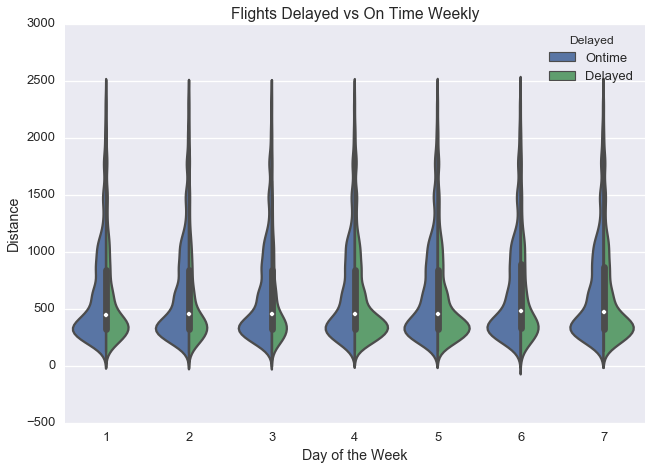

In [24]:
def displayViolinPlot():
    g = sns.violinplot(x = 'DayOfWeek', y = 'Distance', 
                       hue = 'Delayed', data = fd, split = True,
                       scale = 'count', order = np.arange(1, 8, 1))
    g.set_title('Flights Delayed vs On Time Weekly')
    g.set(ylabel = 'Distance', xlabel = 'Day of the Week')

displayViolinPlot()

In conclusion:

* The dataset is relatively well-balanced between the delayed fights and the on-time ones.
* The day of the week and the hour of the day seems to bear some correlations with the on-time/delayed status.
* Some destinations and/or origins seem to be more prone to have delays.
* Lack of monthly/yearly history to extract a pattern on those features (can be dropped)

### 3- Create an Experimental Dataset With Dummy Variables:

The first step is to create a new dataset from the old one with all the necessary dummy variables.

*(NOTA: in below function, the flag `is_copy` is intentionally set to `False` in order to* *suppress an annoying warning; furthermore, a column with the label `Intercept` has been*
*added for the analysis with the `statsmodels` package, which requires an explicit intercept)*

In [25]:
def dataProcess():
    dummy_cols = ['UniqueCarrier', 'Dest', 'Origin', 'DayOfWeek', 'DepHour']
    data = fd[['Distance', 'Delayed']]
    data.is_copy = False
    dummy_vars = {}
    for col in dummy_cols:
        dummy_vars = pd.get_dummies(fd[col], prefix = col)
        #dummy_vars = dummy_vars.drop(dummy_vars.columns[0], axis = 1)
        data = data.join(dummy_vars)
    data.replace({'Delayed' : {'Ontime' : 0, 'Delayed' : 1}}, inplace = True)
    return data

In [26]:
dataProcess().head()

,Distance,Delayed,UniqueCarrier_WN,UniqueCarrier_XE,Dest_ABQ,Dest_ALB,Dest_AMA,Dest_ATL,Dest_AUS,Dest_BDL,Dest_BFL,Dest_BHM,Dest_BNA,Dest_BOI,Dest_BUF,...,DepHour_8,DepHour_9,DepHour_10,DepHour_11,DepHour_12,DepHour_13,DepHour_14,DepHour_15,DepHour_16,DepHour_17,DepHour_18,DepHour_19,DepHour_20,DepHour_21,DepHour_22
0,810,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,810,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,515,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,515,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,515,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


For the classification, we will split the original dataset with the following proportions:

* __Training dataset__ $\Rightarrow$ 80% of the original data
* __Testing dataset__ $\Rightarrow$ the remaining 20% of the roiginal data

In [27]:
def getTrainingAndTestDataset(data, split = 0.8):
    train_idx = sample(data.index, int(split * len(data)))
    test_idx = data.index.difference(train_idx)
    train_data = data.ix[train_idx,:]
    test_data = data.ix[test_idx,:]
    return train_data, test_data

One ineresting thing would be to check which feature is the most important in the classification process. Using the `feature_selection` package of `scikit-learn`, we can check the f-score of each feature and plot it: 

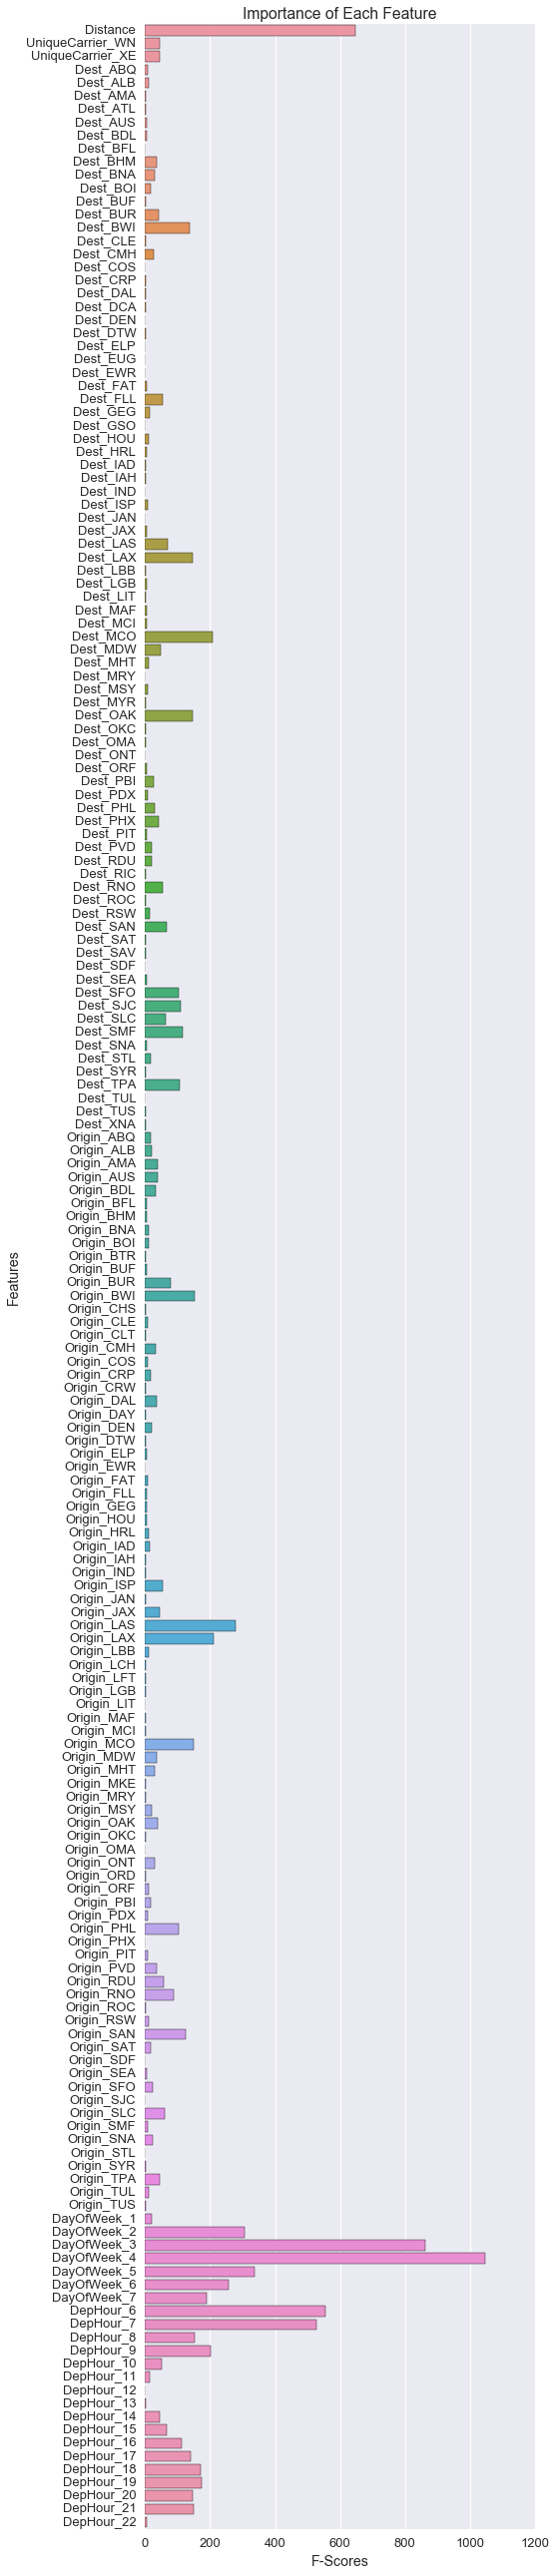

In [28]:
def checkFeatures():
    data = dataProcess()
    X = data.drop(['Delayed'], axis = 1)
    y = data['Delayed']
    F1 = feature_selection.f_classif(X.values, y.values)[0]
    plt.figure(figsize = (7, 45))
    sns.barplot(F1, X.columns, orient = 'h')
    plt.title('Importance of Each Feature')
    plt.xlabel('F-Scores')
    plt.ylabel('Features');
    
checkFeatures()

The most important features (in terms of f-score) are:

* DayOfWeek_3 & DayOfWeek_4
* DepHour_6 & DepHour_7
* Distance

All those features have an f-score higher than 500. The next part will deal with how those features influence the prediction score.

### 4- Predictions & Features

The 2 next helper functions:

* `getFeaturesAboveScore` $\Rightarrow$ takes an integer value as a parameter and returns all features whose f-score exceeds this value.
* `classifScore` $\Rightarrow$ takes a list of features and a regularization value, performs a logistic regression and returns the score.

In [29]:
def getFeaturesAboveScore(score = 100):
    data = dataProcess()
    X = data.drop(['Delayed'], axis = 1)
    y = data['Delayed']
    F1 = feature_selection.f_classif(X.values, y.values)[0]
    f_list = list()
    for i, f in enumerate(F1):
        if f > score:
            f_list.append(X.columns[i])
    return f_list

In [30]:
def classifScore(f_list, c = 1000):
    train_data, test_data = getTrainingAndTestDataset(dataProcess(), 0.6)
    X_train = train_data[f_list].values
    y_train = train_data['Delayed'].values
    X_test = test_data[f_list].values
    y_test = test_data['Delayed'].values
    log_reg = LogisticRegression(C = c)
    log_reg.fit(X_train, y_train)
    return log_reg.score(X_test, y_test)

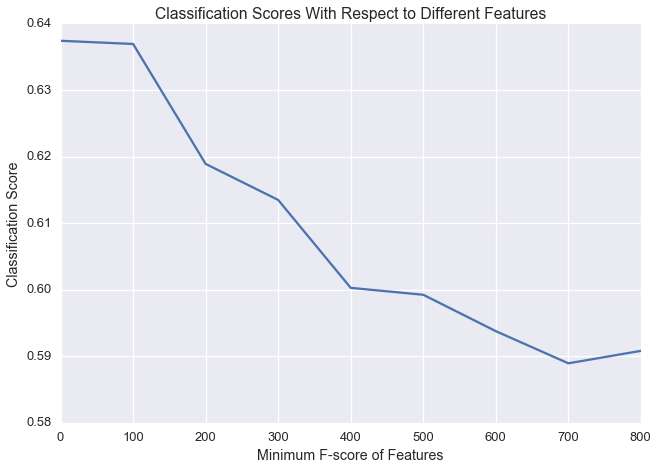

In [31]:
def plotClassificationScore(rng):
    f_range = rng
    scores_list = list()
    for sc in f_range:
        f_list = getFeaturesAboveScore(sc)
        scores_list.append(classifScore(f_list, 1000))
    plt.plot(f_range, scores_list)
    plt.title('Classification Scores With Respect to Different Features')
    plt.xlabel('Minimum F-score of Features')
    plt.ylabel('Classification Score')
    
plotClassificationScore(np.arange(0, 850, 100))

Apparently, diminishing the number of features by keeping the most important ones does not improve the classification score and has actually a negative impact on it...

The best scores is obtained by keeping all the features we created previously. However, let's have a "zoom" on the values between 0 and 100:

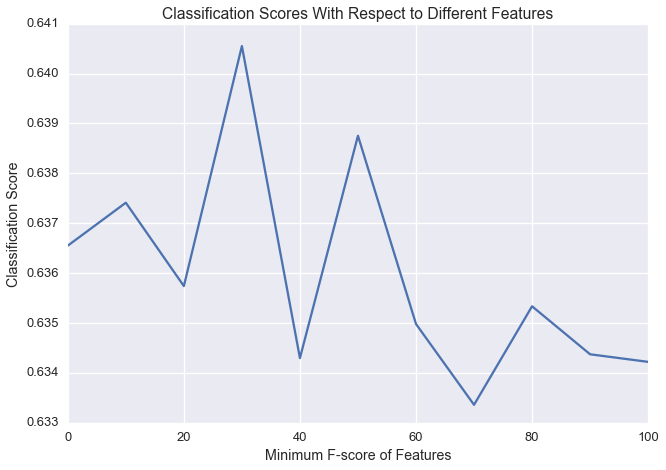

In [32]:
plotClassificationScore(np.arange(0, 110, 10))

Okay, this is quite wiggy... But it looks like we can suppress some noise on the prediction by getting rid off the weakest features. Let's try several iterations to see if this could be stabilized:

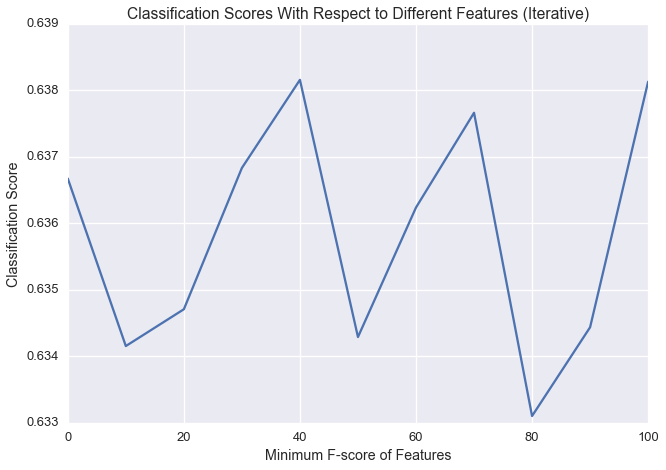

In [42]:
def plotClassificationScoreIterative():
    f_range = np.arange(0, 110, 10)
    scores_list = defaultdict(list)
    for sc in f_range:
        for i in np.arange(0, 100, 5):
            f_list = getFeaturesAboveScore(sc)
            scores_list[sc].append(classifScore(f_list, 1000))
    scores_list = [np.mean(scores_list[k]) for k in scores_list]
    plt.plot(f_range, scores_list)
    plt.title('Classification Scores With Respect to Different Features (Iterative)')
    plt.xlabel('Minimum F-score of Features')
    plt.ylabel('Classification Score')
    
plotClassificationScoreIterative()

So apparently, by setting the minimum f-scores of the features to `30`, `40` or `70`, we can slightly improve the prediction score in a steady way.

However, we kept the regularization parameter at a high value. This may be optimized in a similar way to improve the prediction slightly more.

### 5- Predictions & Regularizations

We will keep the same features as before by setting the minimum f-score to `40`. An iterative validation will be performed to check which value for the regularization parameter performs best and in a steady way:

_(NOTA: the regularization parameter should be strictly positive)_

In [35]:
def plotScoresFromReg(flimit = 100):
    c_range = np.arange(1, 1050, 50)
    f_list = getFeaturesAboveScore(flimit)
    scores_list = defaultdict(list)
    for reg in c_range:
        for i in np.arange(0, 100, 5):
            scores_list[reg].append(classifScore(f_list, reg))
    scores_list = [np.mean(scores_list[k]) for k in scores_list]
    plt.plot(c_range, scores_list)
    plt.xticks(c_range)
    plt.title('Classification Scores with Different Regularization')
    plt.xlabel('Regularization Parameter')
    plt.ylabel('Classification Score')

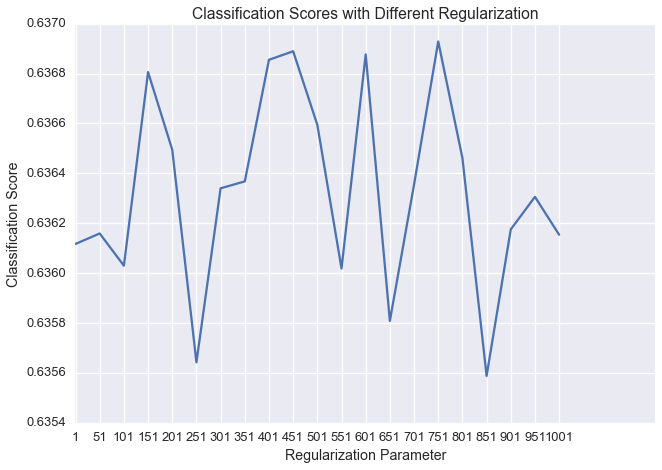

In [36]:
plotScoresFromReg(40)

By selecting a minimum f-score of `40`:

* Best regularization for `750`
* Best score higher than 0.6368

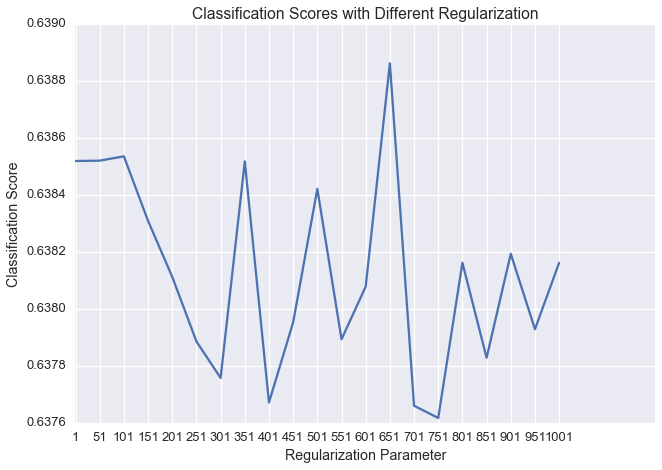

In [40]:
plotScoresFromReg(30)

By selecting a minimum f-score of `30`:

* Best regularization for `650`
* Best score higher than 0.6388

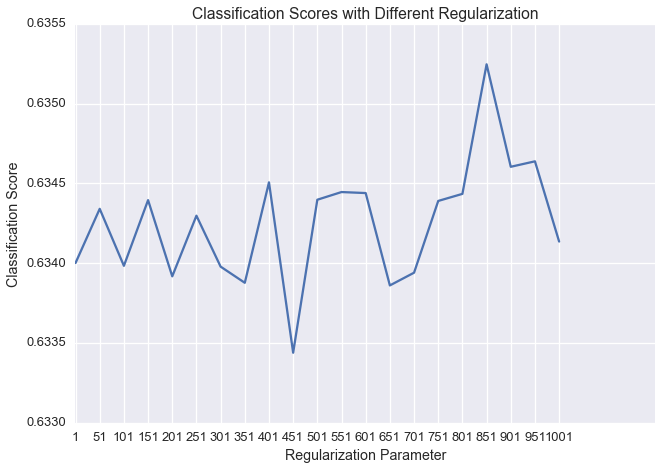

In [43]:
plotScoresFromReg(70)

By selecting a minimum f-score of `70`:

* Best regularization for `850`
* Best score higher than 0.6355

Turns out the best score may be obtained for a minimum f-score of 30 and a regularization parameter around 650.

Now it's time to perform our final comparison:

In [44]:
def finalComparison(compTuple):
    for fs, rg in compTuple:
        feats = getFeaturesAboveScore(fs)
        scores = []
        iter_range = np.arange(0, 501, 10)
        for i in iter_range:
            scores.append(classifScore(feats, rg))
        print('regularization = {:<4} | score = {:.4f} (minimum f-score = {})'.
              format(rg, np.mean(scores), fs))

In [45]:
finalComparison([(0, 1000),(40, 750), (70, 850), (30, 650)])

regularization = 1000 | score = 0.6368 (minimum f-score = 0)
regularization = 750  | score = 0.6371 (minimum f-score = 40)
regularization = 850  | score = 0.6341 (minimum f-score = 70)
regularization = 650  | score = 0.6385 (minimum f-score = 30)


### 6- Conclusion

The present analysis, though a bit crude, shows how, by carefully suppressing some noise and performing some fine-tuning of the regularization, we can increase the performance of our prediction, with respect to the default conditions.

The final score is `0.6385`. In order to get an even better score, one may have to use more refined techniques.